## Crack Detection using DL

#### Imports

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import cv2
import shutil
from shutil import copyfile
import random

import keras
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator # from keras.preprocessing.image import ImageDataGenerator is deprecated
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import smart_resize

#### Data Preparation

In [10]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    loss = history.history['loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'Train Accuracy: {str(round(acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Train Loss: {str(round(loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

In [36]:
train_dir = '/kaggle/input/crack-detection/Crack Detection/train'
test_dir = '/kaggle/input/crack-detection/Crack Detection/test'

In [4]:
train_ds = keras.utils.image_dataset_from_directory(
    directory= train_dir,
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels=None,
    label_mode=None,
    batch_size=32,
    image_size=(256, 256)
)

Found 14968 files belonging to 2 classes.
Found 2000 files belonging to 1 classes.


#### Approach 1: CNN

In [5]:
# Model Definition
INPUT_SHAPE = (256, 256, 3)

model = keras.Sequential()

model.add(Conv2D(32, (3, 3), input_shape = INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [6]:
model.compile(loss='binary_crossentropy',
             optimizer='Adam',
             metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 activation (Activation)     (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 125, 125, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                    

In [9]:
history = model.fit(train_ds,
                  batch_size = 32,
                  verbose=1,
                  epochs=20,
                  validation_data=validation_ds,
                  shuffle=False)

Epoch 1/20
468/468 [==============================] - 22s 47ms/step - loss: 0.6390 - accuracy: 0.5976 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
468/468 [==============================] - 22s 46ms/step - loss: 0.6263 - accuracy: 0.6080 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/20
468/468 [==============================] - 26s 55ms/step - loss: 0.6578 - accuracy: 0.5625 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/20
468/468 [==============================] - 20s 43ms/step - loss: 0.6934 - accuracy: 0.4988 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/20
468/468 [==============================] - 22s 46ms/step - loss: 0.6932 - accuracy: 0.4934 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/20
468/468 [==============================] - 22s 46ms/step - loss: 0.6932 - accuracy: 0.4935 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/20
468/468 [==============================] - 21s 45ms/step - loss: 0.6932 - acc

Val_loss and Val_accuracy will be zero here because validation data doesn't have classes. We have to predict them.

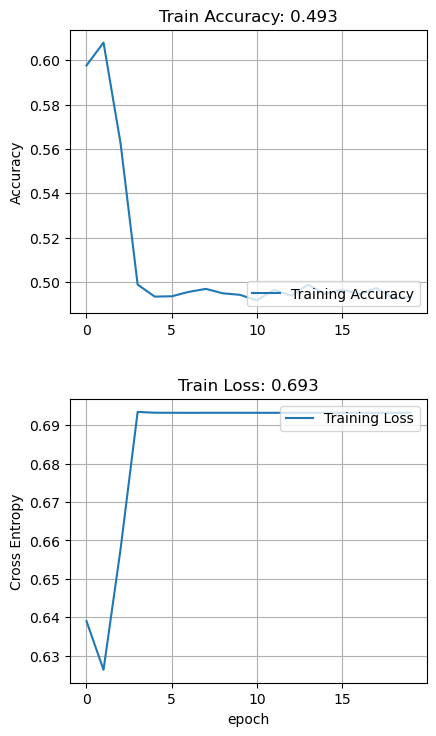

In [11]:
plot_history(history)

1/1 [==============================] - 0s 21ms/step
Cracked


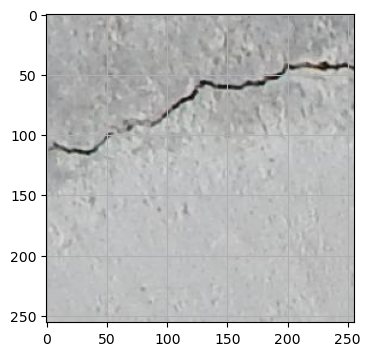

In [24]:
image_path = os.path.join('/kaggle/input/crack-detection/Crack Detection/test/1009.jpg')
image = load_img(image_path)
plt.imshow(image)
image = smart_resize(image, (256, 256))
image = img_to_array(image) / 255.0 
image = np.expand_dims(image, axis=0)
pred = model.predict(image)
if pred < 0.5:
    print("Cracked")
else:
    print("Uncracked")

#### Approach 2: VGG16

In [25]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False
last_output = base_model.output
x = tf.keras.layers.Flatten()(last_output)  # Flatten the output layer to 1 dimension
x = tf.keras.layers.Dense(1024, activation='relu')(x)   # Add a fully connected layer with 1024 hidden units and ReLU activation
x = tf.keras.layers.Dropout(0.6)(x) # Add dropout for regularization
predictions = Dense(1, activation='sigmoid')(x) 

58889256/58889256 [==============================] - 2s 0us/step


In [26]:
# Create the final model
vgg16_model = Model(inputs=base_model.input, outputs=predictions)

In [27]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [28]:
vgg16_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [37]:
# Train the model
history = vgg16_model.fit(train_ds,
                       epochs=20,
                       validation_data=validation_ds,
                       verbose=1)

Epoch 1/20
468/468 [==============================] - 45s 94ms/step - loss: 0.3566 - accuracy: 0.8312 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
468/468 [==============================] - 44s 94ms/step - loss: 0.3521 - accuracy: 0.8325 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/20
468/468 [==============================] - 44s 94ms/step - loss: 0.3353 - accuracy: 0.8386 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/20
468/468 [==============================] - 45s 95ms/step - loss: 0.3248 - accuracy: 0.8389 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/20
468/468 [==============================] - 44s 94ms/step - loss: 0.3134 - accuracy: 0.8492 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/20
468/468 [==============================] - 45s 96ms/step - loss: 0.3093 - accuracy: 0.8529 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/20
468/468 [==============================] - 45s 96ms/step - loss: 0.3024 - acc

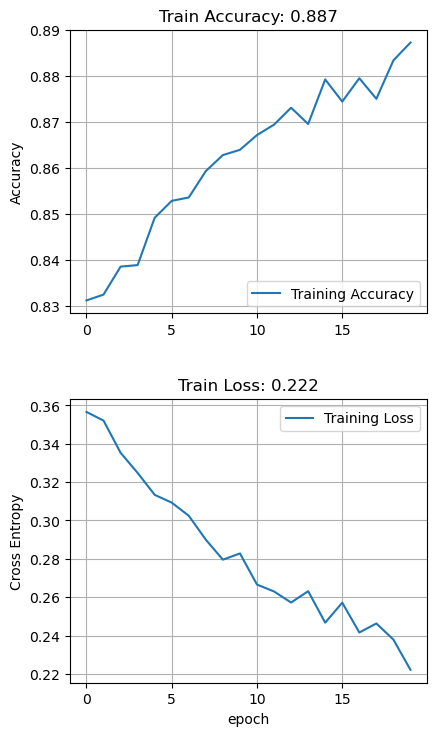

In [38]:
plot_history(history)

#### Approach 3: ResNet50

In [39]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False
last_output = base_model.output 
x = tf.keras.layers.Flatten()(last_output)  # Flatten the output layer to 1 dimension
x = tf.keras.layers.Dense(1024, activation='relu')(x)   # Add a fully connected layer with 1024 hidden units and ReLU activation
x = tf.keras.layers.Dropout(0.6)(x) # Add dropout for regularization
predictions = Dense(1, activation='sigmoid')(x) 

94765736/94765736 [==============================] - 3s 0us/step


In [40]:
# create the final model
resnet50_model = Model(inputs=base_model.input, outputs=predictions)
resnet50_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [41]:
resnet50_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [42]:
# Train the model
history = model.fit(train_ds,
                       epochs=20,
                       validation_data=validation_ds,
                       verbose=1)

Epoch 1/20
468/468 [==============================] - 22s 47ms/step - loss: 0.6932 - accuracy: 0.4938 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
468/468 [==============================] - 27s 57ms/step - loss: 0.6932 - accuracy: 0.4945 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/20
468/468 [==============================] - 21s 43ms/step - loss: 0.6932 - accuracy: 0.4929 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/20
468/468 [==============================] - 20s 43ms/step - loss: 0.6932 - accuracy: 0.4903 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/20
468/468 [==============================] - 22s 46ms/step - loss: 0.6932 - accuracy: 0.4966 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/20
468/468 [==============================] - 21s 44ms/step - loss: 0.6932 - accuracy: 0.4951 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/20
468/468 [==============================] - 21s 45ms/step - loss: 0.6932 - acc

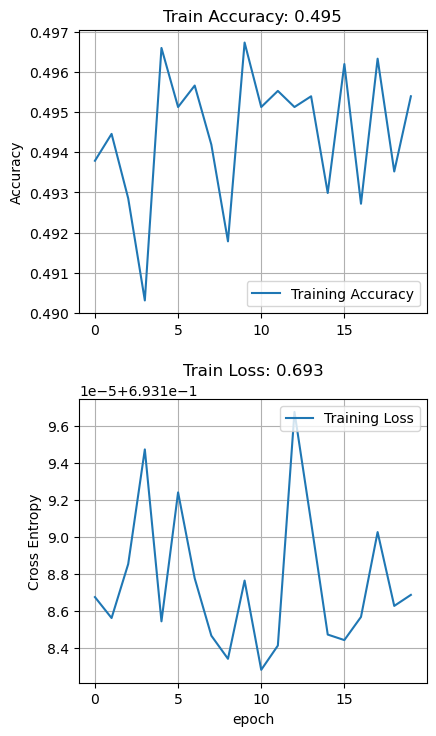

In [43]:
plot_history(history)